# Benchmark Cubic and Linear code
This notebook will be used to benchmark BigDFT (cubic mode, free boundary condition).

## Remote Infrastructure
This routine generates an input file with the parameters we want to test.

In [1]:
import yaml
new = """
import: linear
perf:
  check_sumrho: 0
  check_overlap: 0
lin_general:
  charge_multipoles: 0
  output_mat: 0"""
lin_dict = yaml.safe_load(new)

In [2]:
def input_template(linear=False):
    import BigDFT.Inputfiles as I
    # Basic Input Parameters 
    inp = I.Inputfile()
    inp.set_xc("PBE")
    inp.set_hgrid(0.5)
    inp.set_rmult(coarse=5.0, fine=7.0) 
    # Get the PSP directory
    inp.set_psp_nlcc()   
    if linear:
        inp.update(lin_dict)
    return inp

In [3]:
def treat_structure(filename,jobname,**kwargs):
    from BigDFT.Calculators import SystemCalculator
    from os.path import join, basename, isfile
    from BigDFT.IO import read_pdb
    from futile.Utils import create_tarball
    sys = read_pdb(open(filename), ignore_connectivity=True, ignore_unit_cell=True)    
    code = SystemCalculator()
    log = code.run(posinp=sys.get_posinp(),name=jobname,**kwargs)
    #if isfile('forces_'+jobname+'.yaml') :
    target = jobname+'.tar.gz'
    dry_run = kwargs.get('dry_run',False)
    files = ['log-'+jobname+'.yaml']
    if dry_run:
        print(log.log['Total Number of Orbitals'], log.log['Estimated Memory Peak (MB)'])
        create_tarball(target, files=files)
    else:        
        print(log.energy)
        for timefile in [join('data-'+jobname+',time-'+jobname+'.yaml'),'time-'+jobname+'.yaml']:
            if isfile(timefile):
                files += [timefile]
                break
        create_tarball(target,
                       files=files)
    return target

In [5]:
computer = "irene" # "archer2"  # "vega"
systems = "2CzPN"
linear = True #False

In [6]:
lincub='linear' if linear else 'cubic'
rundirs={'irene': ('/ccc/work/cont003/gen12049/genovesl/2022_remote_bench/2Cz_PN-start/' + lincub,
                   'local_work_irene_gnu_' + lincub),
         'hokusai': ('/home/wddawson/runs/2022/remote_benchmark',
                     'local_work_hokusai'),
         'archer2': ('/work/e572/e572/shared/bench/cubic_test/run_2CzPN',
                     '/work/e572/e572/shared/bench/cubic_test/run_2CzPN'),
         'vega': ('/ceph/hpc/home/eugenovesel/remote_bench/intel/2Cz_PN/' + lincub,
                  'local_work_vega_intel/' + lincub)}
remote_dir, local_dir = rundirs[computer]

This is the full remote routine we want to run to handle a given structure.

## Local Dataset
This routine processes a single file.

In [6]:
def treat_pdb(filename, inp, name, remote_dir, local_dir, submission_script, url=None, **kwargs):
    from BigDFT.RemoteRunners import computer_runner
    from os.path import basename
    arguments = dict(filename=basename(filename), input=dict(inp),
                     jobname=name, **kwargs)
    submission_script.jobname = name
    run_pdb = computer_runner(treat_structure,
                              submission_script=submission_script, url=url,
                              arguments=arguments,
                              required_files=[filename],
                              output_files=[name+'.tar.gz'],
                              name=name,
                              remote_dir=remote_dir, local_dir=local_dir)
    return run_pdb

This function creates an entire dataset.

In [7]:
def get_dataset(run_spec,remote_dir,local_dir,submission_script,url=None,
                database_file="database.yaml",**kwargs):
    from BigDFT.RemoteRunners import RemoteDataset
    from os.path import basename, join, relpath
    all_runs = RemoteDataset(run_dir='.',remote_dir=remote_dir, local_dir=local_dir,
                             database_file=join(local_dir,database_file),url=url)
    for file, runs in run_spec.items():
        filename = basename(file)
        for run in runs:
            submission_script.update(run)
            # print(submission_script)
            size = str(submission_script.mpi)+'-'+str(submission_script.omp)
            name = filename+'-'+size
            submission_script['name'] = name
            submission_script['jobname'] = name            
            runner = treat_pdb(relpath(file,start=local_dir),input_template(linear=linear),
                               name,remote_dir, None, submission_script,url,**kwargs)
            all_runs.append_run(id={filename:size}, remote_runner=runner)
    return all_runs

## Remote Calculation
First we use the data to setup our remote specs.

In [8]:
from futile.Utils import file_list
allfiles=file_list(directory='input',prefix='2CzPN', suffix='.pdb',include_directory_path=True)
newspec={}
for f in allfiles:
    num=f.split('_')[-1].split('.')[0]
    # print(f,num)
    nmol=int(num)
    start=int(nmol/10)
    end=int(nmol/2)+4
    newruns=[{'mpi':32*(i+1),'omp':4} for i in range(start,end,int((end-start)/4)+1)]
    newspec[f]=newruns

In [8]:
#newspec

In [8]:
bench_spec = {'input/2CzPN_1.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4}],
 'input/2CzPN_2.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4}],
 'input/2CzPN_4.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4}],
 'input/2CzPN_6.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4}],
 'input/2CzPN_8.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4},
  {'mpi': 192, 'omp': 4}],
 'input/2CzPN_10.pdb': [{'mpi': 32, 'omp': 4},
  {'mpi': 64, 'omp': 4},
  {'mpi': 96, 'omp': 4},
  {'mpi': 128, 'omp': 4},
  {'mpi': 160, 'omp': 4},
  {'mpi': 192, 'omp': 4}]}

Import the computer.

In [9]:
if computer == "irene":
    from BigDFT.Database.computers.irene import submission_script_gnu as remote_script, url as remote_url
    remote_script.time=1800
elif computer == "hokusai":
    remote_script = submission_script
    remote_url = url
    remote_script.time = "00:30:00"
elif computer == 'archer2':
    from BigDFT.Database.computers.archer2 import submission_script as remote_script, url as remote_url
    
    required = {'project':'e572',
                'time':'0:05:00'}
    remote_script.update(required)
elif computer == 'vega':
    from BigDFT.Database.computers.vega import submission_script_intel as remote_script, url as remote_url
    remote_script.time=10


Launch the remote jobscript.

In [10]:
remote_dataset = get_dataset(bench_spec,
                                 submission_script=remote_script,
                                 database_file=computer + lincub + ".yaml",
                                 url=remote_url,remote_dir=remote_dir,local_dir=local_dir)

In [12]:
print(remote_script)

#!/bin/bash -l
#SBATCH -J 2CzPN_10.pdb-192-4
#SBATCH -n 192
#SBATCH -N 3
#SBATCH -c 4
#SBATCH -t 10
#SBATCH -p cpu
#SBATCH -o 2CzPN_10.pdb-192-4.o
#SBATCH -e 2CzPN_10.pdb-192-4.e
export PREFIX=/ceph/hpc/data/d2021-135-users/softwares/BigDFT/binaries/install
module purge
module load SciPy-bundle/2022.05-intel-2022a
module load CMake/3.23.1-GCCcore-11.3.0
module load Meson/0.62.1-GCCcore-11.3.0
source $PREFIX/bin/bigdftvars.sh
export OMPI_MCA_orte_base_help_aggregate=0
#export OMPI_MCA_coll="^ghc,tuned"
#export MKL_DEBUG_CPU_TYPE=5
export BIGDFT_MPIRUN=mpirun
export FUTILE_PROFILING_DEPTH=0
export OMP_NUM_THREADS=$SLURM_CPUS_PER_TASK




In [13]:
#remote_dataset.database.clean()

In [11]:
def get_sshpass(passwordfile):
    from os import environ
    pf = open(passwordfile)
    pw = pf.readlines()[0].rstrip('/n')
    pf.close()
    environ['SSHPASS']=pw
if computer == 'irene':
    get_sshpass('/tmp/irene')
    remote_url.ssh='sshpass -e ssh irene'
    remote_url.set_rsync_command('sshpass -e rsync')

In [12]:
remote_dataset.url.verbose=True
remote_dataset.run()

cmd returned: 
cmd returned: 
sending ['2CzPN_1.pdb__32-4-run.sh', '2CzPN_1.pdb-32-4-function-files.tar.gz', '../../input/2CzPN_1.pdb', '2CzPN_1.pdb-32-4-function-run.py', '2CzPN_1.pdb__64-4-run.sh', '2CzPN_1.pdb-64-4-function-files.tar.gz', '../../input/2CzPN_1.pdb', '2CzPN_1.pdb-64-4-function-run.py', '2CzPN_1.pdb__96-4-run.sh', '2CzPN_1.pdb-96-4-function-files.tar.gz', '../../input/2CzPN_1.pdb', '2CzPN_1.pdb-96-4-function-run.py', '2CzPN_1.pdb__128-4-run.sh', '2CzPN_1.pdb-128-4-function-files.tar.gz', '../../input/2CzPN_1.pdb', '2CzPN_1.pdb-128-4-function-run.py', '2CzPN_2.pdb__32-4-run.sh', '2CzPN_2.pdb-32-4-function-files.tar.gz', '../../input/2CzPN_2.pdb', '2CzPN_2.pdb-32-4-function-run.py', '2CzPN_2.pdb__64-4-run.sh', '2CzPN_2.pdb-64-4-function-files.tar.gz', '../../input/2CzPN_2.pdb', '2CzPN_2.pdb-64-4-function-run.py', '2CzPN_2.pdb__96-4-run.sh', '2CzPN_2.pdb-96-4-function-files.tar.gz', '../../input/2CzPN_2.pdb', '2CzPN_2.pdb-96-4-function-run.py', '2CzPN_2.pdb__128-4-run.sh'

/opt/bigdft/install/lib/python3.9/site-packages/BigDFT/URL.py:531: UserWarning: Failed to add the ECDSA host key for IP address '153.5.68.43' to the list of known hosts (/home/genovese/.ssh/known_hosts).

  warn(str(err), UserWarning)


{0: None,
 1: None,
 2: None,
 3: None,
 4: None,
 5: None,
 6: None,
 7: None,
 8: None,
 9: None,
 10: None,
 11: None,
 12: None,
 13: None,
 14: None,
 15: None,
 16: None,
 17: None,
 18: None,
 19: None,
 20: None,
 21: None,
 22: None,
 23: None,
 24: None,
 25: None,
 26: None,
 27: None,
 28: None,
 29: None,
 30: None}

In [13]:
finished=remote_dataset.is_finished(verbose=False)

In [13]:
remote_data = remote_dataset.fetch_results()#lookup=[k for k, v in finished.items() if v])

cmd returned: 2CzPN_1.pdb-128-4-function-files.tar.gz
2CzPN_1.pdb-128-4-function-run.py
2CzPN_1.pdb-32-4-function-files.tar.gz
2CzPN_1.pdb-32-4-function-run.py
2CzPN_1.pdb-64-4-function-files.tar.gz
2CzPN_1.pdb-64-4-function-run.py
2CzPN_1.pdb-96-4-function-files.tar.gz
2CzPN_1.pdb-96-4-function-run.py
2CzPN_1.pdb__128-4-run.sh
2CzPN_1.pdb__32-4-run.sh
2CzPN_1.pdb__64-4-run.sh
2CzPN_1.pdb__96-4-run.sh
2CzPN_10.pdb-128-4-function-files.tar.gz
2CzPN_10.pdb-128-4-function-run.py
2CzPN_10.pdb-160-4-function-files.tar.gz
2CzPN_10.pdb-160-4-function-run.py
2CzPN_10.pdb-192-4-function-files.tar.gz
2CzPN_10.pdb-192-4-function-run.py
2CzPN_10.pdb-32-4-function-files.tar.gz
2CzPN_10.pdb-32-4-function-run.py
2CzPN_10.pdb-64-4-function-files.tar.gz
2CzPN_10.pdb-64-4-function-run.py
2CzPN_10.pdb-96-4-function-files.tar.gz
2CzPN_10.pdb-96-4-function-run.py
2CzPN_10.pdb__128-4-run.sh
2CzPN_10.pdb__160-4-run.sh
2CzPN_10.pdb__192-4-run.sh
2CzPN_10.pdb__32-4-run.sh
2CzPN_10.pdb__64-4-run.sh
2CzPN_10.pdb

## Plot Results
Now let's plot the times and memory usage.

In [9]:
def extract_results(directory):
    from futile.Utils import file_list
    import tarfile
    from os.path import join
    from os import system
    for archive in file_list(directory,suffix='.tar.gz',exclude='files',include_directory_path=True):
        arch = tarfile.open(archive)
        arch.extractall(path=directory)
        arch.close()
    system('sed -i s/^\ *\:\ null/\ \ \ \ null/g '+join(directory,'time*'))
    system('sed -i s/^\ *\:\ null/\ \ \ \ null/g '+join(directory,'data*','time*'))

In [20]:
# def extract_results(remote_data,directory):
#     import tarfile
#     from os.path import join
#     for archive in remote_data:
#         arch = tarfile.open(join(directory,archive))
#         arch.extractall(path=directory)
#         arch.close()

In [10]:
extract_results(directory=local_dir)

sed: can't read local_work_irene_gnu_linear/data*/time*: No such file or directory


In [55]:
!for t in `ls local_fugaku/time*yaml`; do sed -i  s/\:\ null/\#\:\ null/g $t; done

In [11]:
def mol_mpi_omp(filename):
    sp = filename.split('_')[-1].replace('.pdb','').replace('.yaml','')
    return tuple([int(d) for d in sp.split('-')])
    

In [12]:
def get_time_files(directory):
    from futile.Utils import file_list
    from os.path import join
    return {mol_mpi_omp(timefile):join(directory,timefile) 
            for timefile in file_list(directory,prefix='time',suffix='.yaml')}
def get_log_files(directory):
    from BigDFT.Logfiles import Logfile
    from futile.Utils import file_list
    from os.path import join
    return {mol_mpi_omp(logfile): Logfile(logfile)
            for logfile in file_list(directory,prefix='log',suffix='.yaml',include_directory_path=True)}
    

In [13]:
alllogs=get_log_files(local_dir)

In [14]:
alltimings=get_time_files(local_dir)

In [15]:
def get_mol_quantity(data,nmol):
    tmp = {m*o:t for (n,m,o),t in data.items() if n==nmol}
    return [tmp[k] for k in sorted(tmp)]
def get_mpi_quantity(data,nmpi):
    tmp = {n:t for (n,m,o),t in data.items() if m==nmpi}
    return [tmp[k] for k in sorted(tmp)]
def get_ratio_quantity(data,nmpiratio):
    tmp = {n:t for (n,m,o),t in data.items() if m/n==nmpiratio}
    return [tmp[k] for k in sorted(tmp)]


In [16]:
from futile import Time

In [59]:
plottype='Seconds'

In [94]:
def put_a_lid_on_it(title):
    import matplotlib.pyplot as plt
    ax=plt.gca()
    fig=ax.get_figure()
    axs=fig.get_axes()
    for iax,ax in enumerate(axs):
        if iax > 0:
            continue
        ax.set_title(title)
    axs[2].set_visible(False)
    fig.savefig(title+'.png')

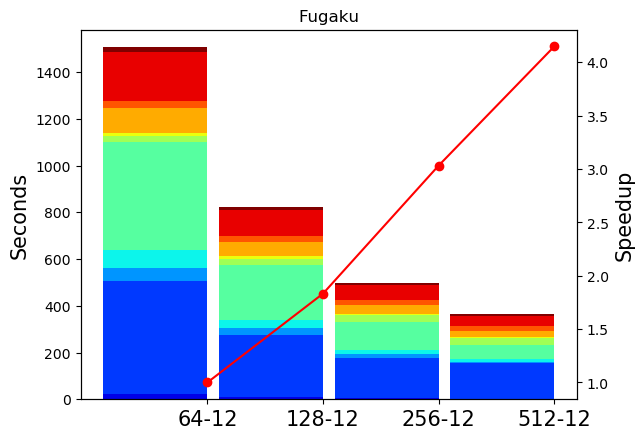

In [95]:
tt=Time.TimeData(*['local_fugaku/time'+key+'.yaml' for key in ['B','A','C','D']],static=True,nokey=True,plottype=plottype)
put_a_lid_on_it('Fugaku')

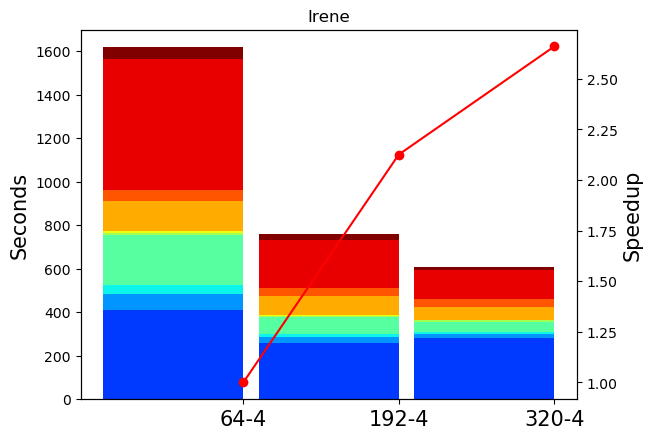

In [96]:
tt=Time.TimeData(*get_mol_quantity(alltimings,18),static=True,nokey=True,plottype=plottype)
put_a_lid_on_it('Irene')

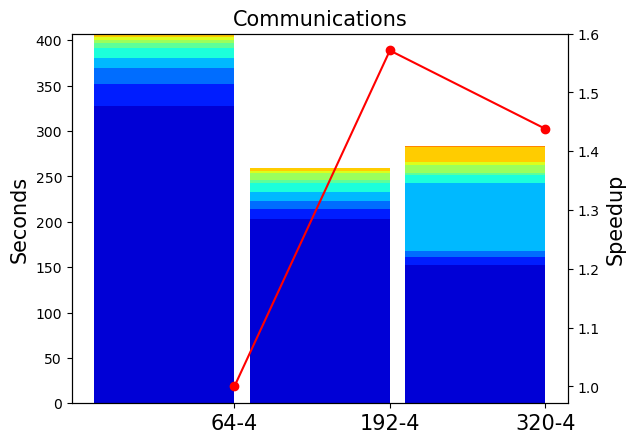

In [66]:
tt.inspect_category('Communications')

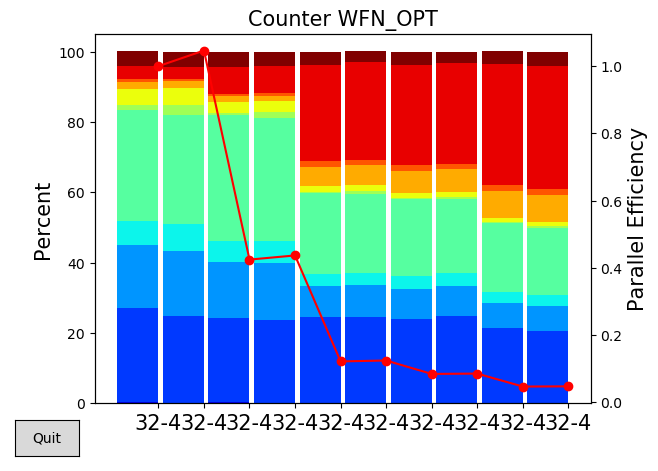

In [18]:
tt=Time.TimeData(*get_mpi_quantity(alltimings,32),static=True,nokey=True,plottype=plottype)

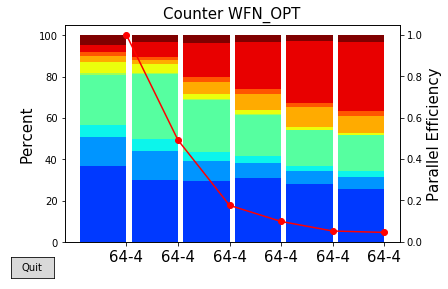

In [67]:
tt=Time.TimeData(*get_mpi_quantity(alltimings,64),static=True,nokey=True,plottype=plottype)

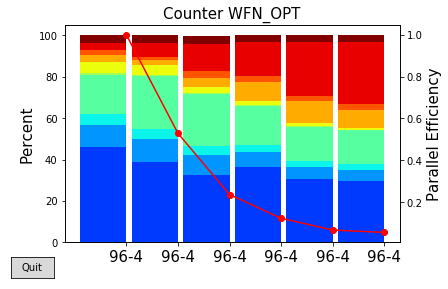

In [68]:
tt=Time.TimeData(*get_mpi_quantity(alltimings,96),static=True,nokey=True,plottype=plottype)

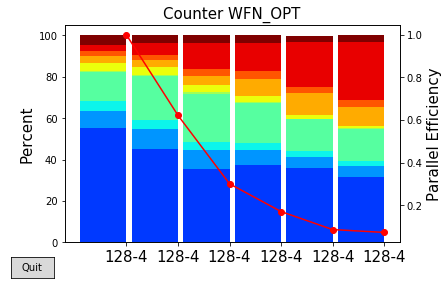

In [70]:
tt=Time.TimeData(*get_mpi_quantity(alltimings,128),static=True,nokey=True,plottype=plottype)

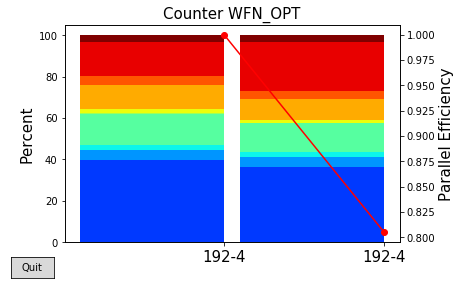

In [72]:
tt=Time.TimeData(*get_mpi_quantity(alltimings,192),static=True,nokey=True,plottype=plottype)

In [24]:
plottype='Percent'#'Seconds'

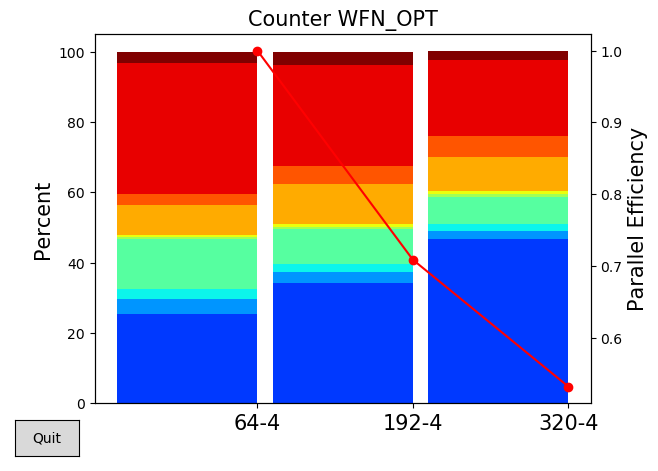

In [25]:
tt=Time.TimeData(*get_mol_quantity(alltimings,18),static=True,nokey=True,plottype=plottype)

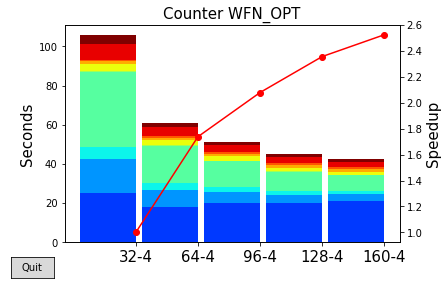

In [39]:
tt=Time.TimeData(*get_mol_quantity(alltimings,2),static=True,nokey=True,plottype=plottype)

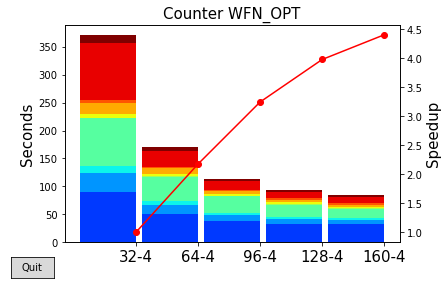

In [47]:
tt=Time.TimeData(*get_mol_quantity(alltimings,4),static=True,nokey=True,plottype=plottype)

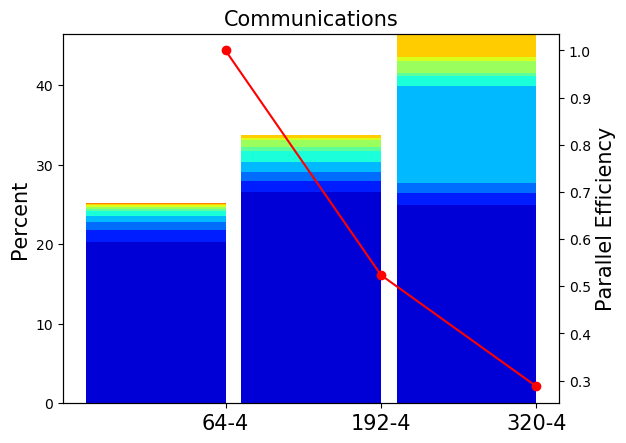

In [26]:
tt.inspect_category('Communications')

In [29]:
def extract_log_info(log):
    ks = {'MPI':'Number of MPI tasks',
          'OMP': 'Maximal OpenMP threads per MPI task',
          'Mem': 'Memory Consumption Report',
          'Walltime': 'Walltime since initialization'      
          }
    data = {k: log.log.get(v) for k,v in ks.items()}
    if data['Mem'] is not None:
        data['Mem'] = float(data['Mem']['Memory occupation']['Memory Peak of process'].rstrip('MB'))
    data['Nat'] = len(log.astruct['positions'])
    return data

In [36]:
data = {log.label:extract_log_info(log) for log in alllogs.values()}

In [38]:
from pandas import DataFrame
df=DataFrame(data).T.dropna()

In [41]:
import seaborn as sns

In [51]:
df.columns

Index(['MPI', 'OMP', 'Mem', 'Walltime', 'Nat', 'cores', 'TotMem', 'CPUhours',
       'CPUmin/at', 'Memory/at'],
      dtype='object')

In [42]:
df['cores']=df['MPI']*df['OMP']
df['TotMem']=df['MPI']*df['Mem']
df['CPUhours']=df['cores']*df['Walltime']/3600.0
df['CPUmin/at']=df['CPUhours']*60.0/df['Nat']
df['Memory/at']=df['TotMem']/df['Nat']

/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


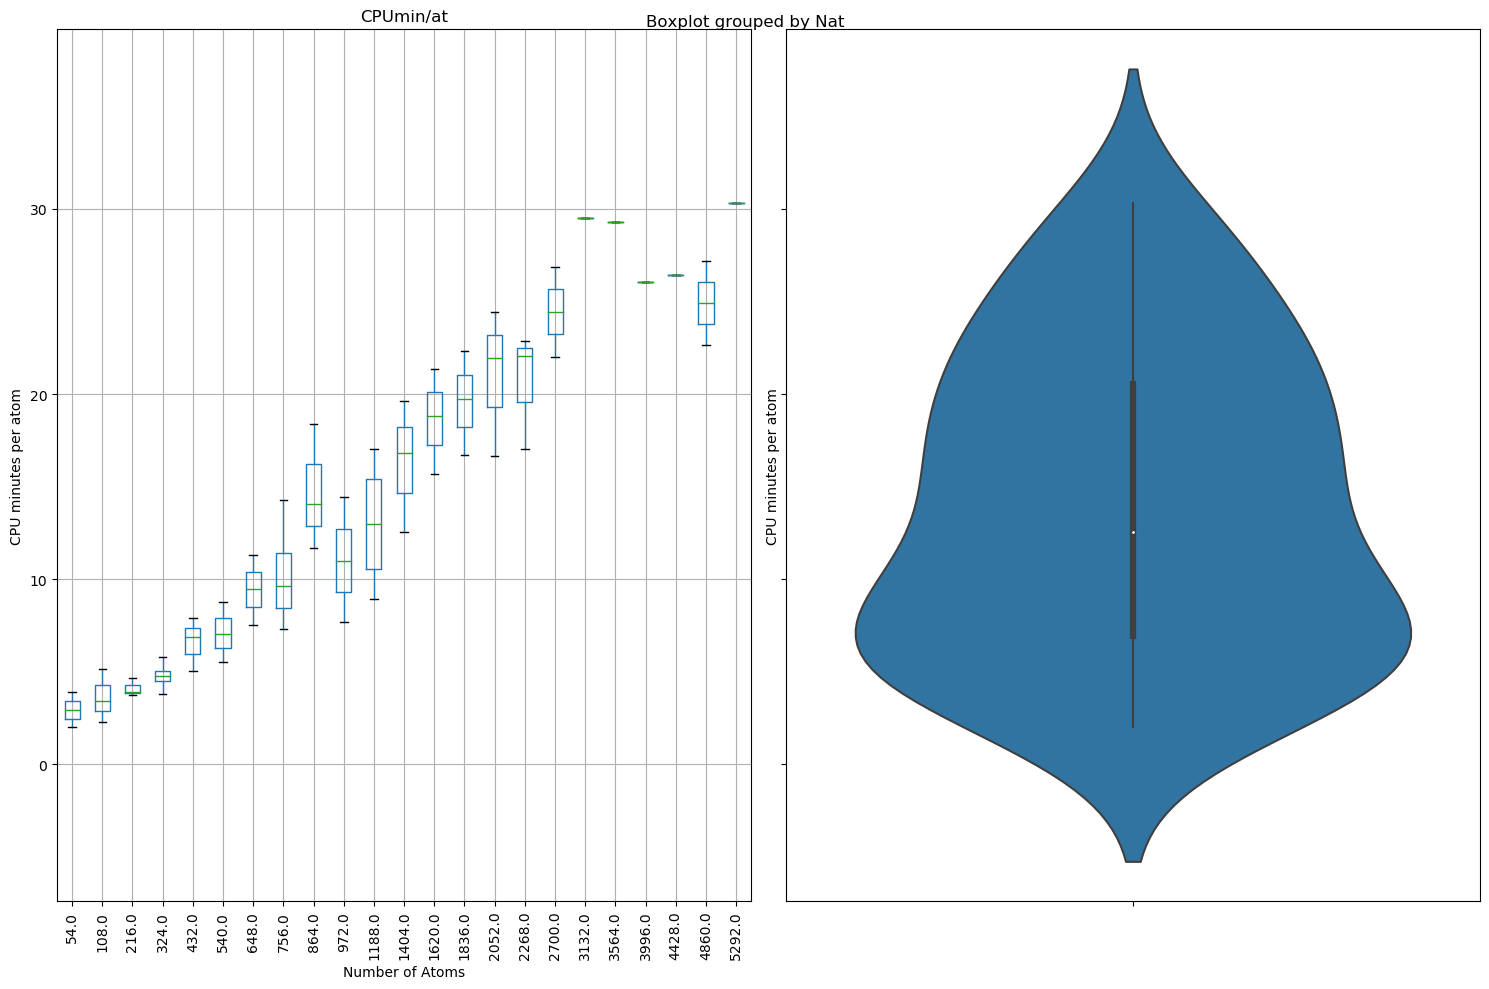

In [53]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(15,10),sharey=True)
df.boxplot(column=['CPUmin/at'],by='Nat',ax=axs[0])
axs[0].set_xlabel('Number of Atoms')
axs[0].set_xticklabels(axs[0].get_xticklabels(),rotation=90)
axs[0].set_ylabel('CPU minutes per atom')
sns.violinplot(data=df,y='CPUmin/at',by='Nat',ax=axs[1])
axs[1].set_ylabel('CPU minutes per atom')
fig.tight_layout()

/opt/intel/oneapi/intelpython/latest/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1426: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


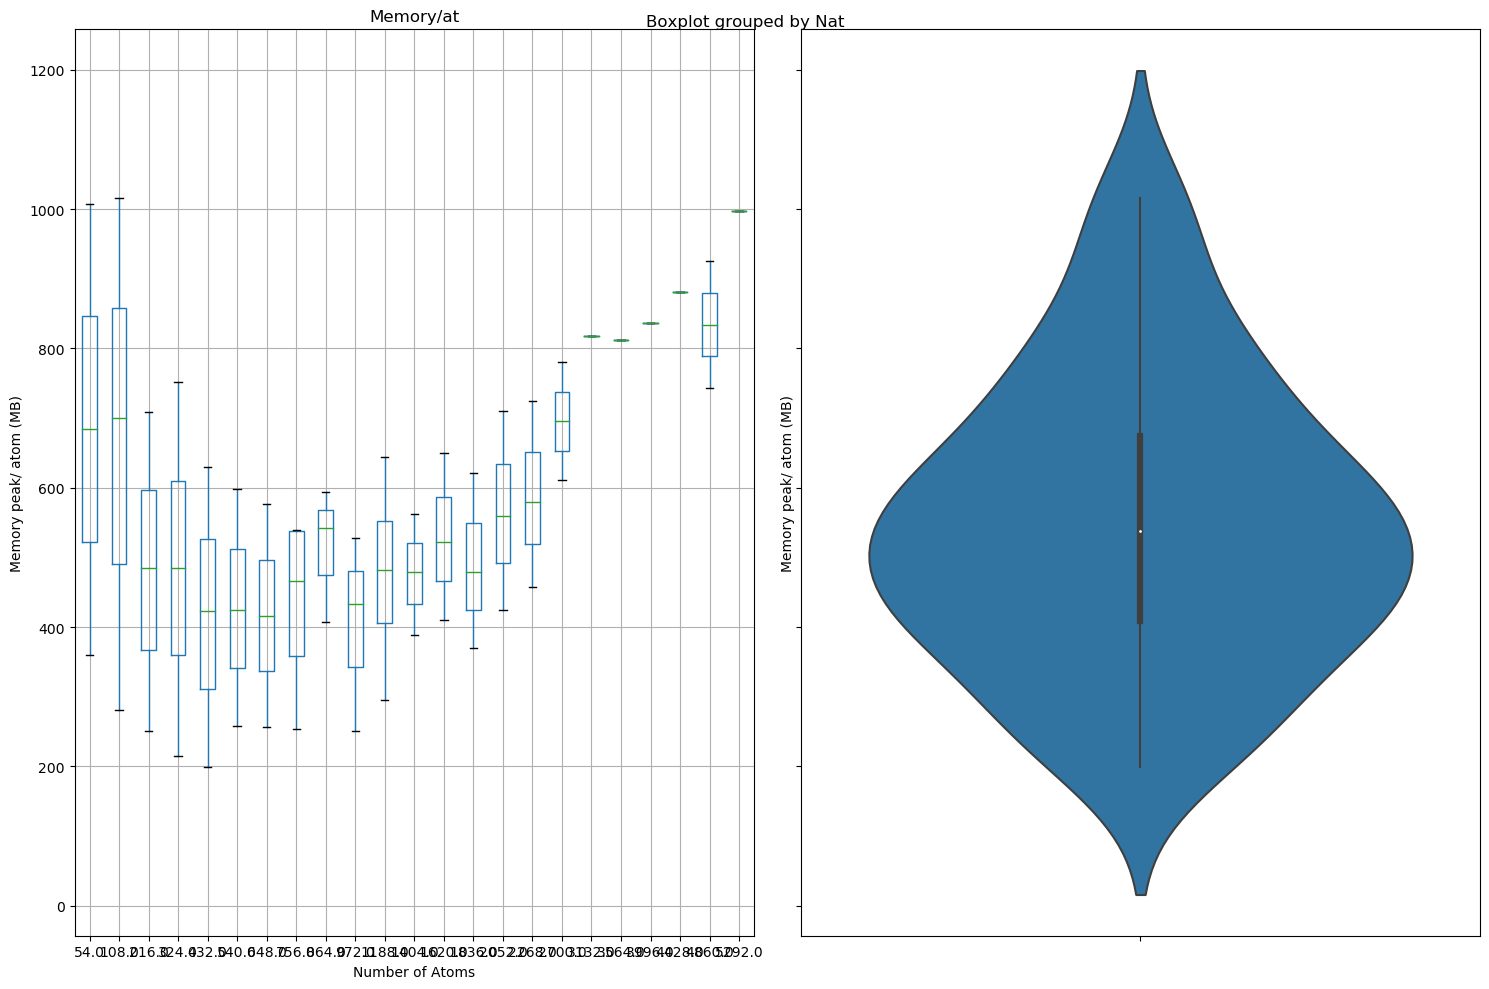

In [44]:
fig, axs = plt.subplots(1,2,figsize=(15,10),sharey=True)
df.boxplot(column=['Memory/at'],by='Nat',ax=axs[0])
axs[0].set_xlabel('Number of Atoms')
axs[0].set_ylabel('Memory peak/ atom (MB)')
sns.violinplot(data=df,y='Memory/at',by='Nat',ax=axs[1])
axs[1].set_ylabel('Memory peak/ atom (MB)')
fig.tight_layout()


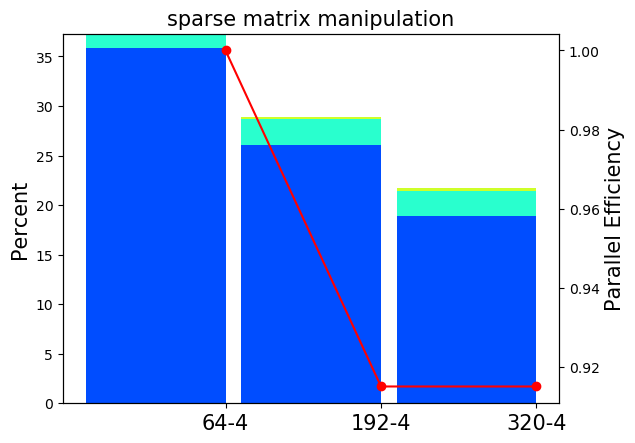

In [27]:
tt.inspect_category('sparse matrix manipulation')

In [50]:
[l.energy if hasattr(l,'energy') else None for l in get_mol_quantity(alllogs,4)]

[-1051.7827827837646,
 -1051.7827827837627,
 -1051.7827827837682,
 -1051.7827827837646,
 -1051.782782783761]

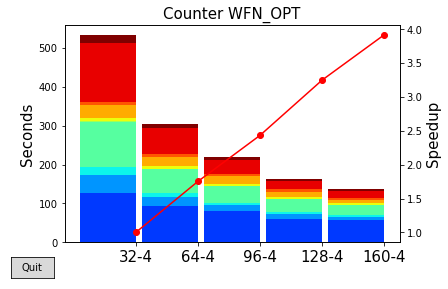

In [52]:
tt=Time.TimeData(*get_mol_quantity(alltimings,6),static=True,nokey=True,plottype=plottype)

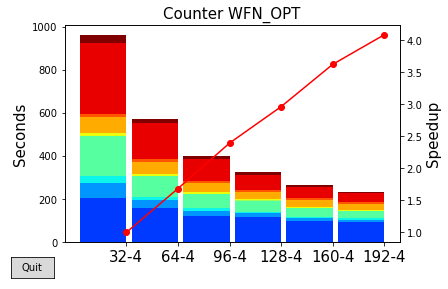

In [53]:
tt=Time.TimeData(*get_mol_quantity(alltimings,8),static=True,nokey=True,plottype=plottype)

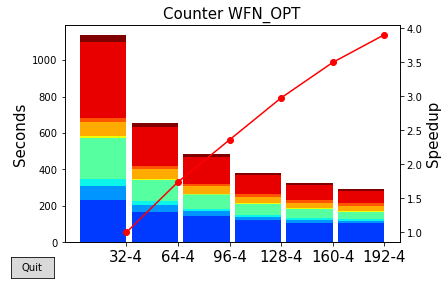

In [54]:
tt=Time.TimeData(*get_mol_quantity(alltimings,10),static=True,nokey=True,plottype=plottype)

In [ ]:
# from matplotlib import pyplot as plt
# from matplotlib.ticker import ScalarFormatter

# fig, axs = plt.subplots(1,3,figsize=(12, 4))

# axs[0].set_title("Total Time", fontsize=15)
# axs[1].set_title("SCF Time", fontsize=15)
# axs[2].set_title("Memory Peak", fontsize=15)

# for name, lset in logs.items():
#     nvals = []
#     tvals = []
#     svals = []
#     mvals = []
#     for n, log in lset.items():
#         try:
#             mvals.append(log.memory_peak / 1024)
#             tvals.append(log.log["Walltime since initialization"])
#             svals.append(times[name][n]["WFN_OPT"][1])
#             nvals.append(n * runner_args["ppn"]*runner_args["omp"])
#         except AttributeError:
#             continue
    
#     axs[0].plot(nvals, tvals, linestyle='--', marker='o', markersize=10)
#     axs[1].plot(nvals, svals, linestyle='--', marker='o', markersize=10)
#     axs[2].plot(nvals, mvals, linestyle='--', marker='o', markersize=10, 
#                 label="("+name.replace("_",")"))
#     axs[2].legend(bbox_to_anchor=(1.47,1))
    
#     axs[0].set_ylabel("Time (s)", fontsize=12)
#     axs[2].set_ylabel("Memory (GB)", fontsize=12)
#     for i in range(3):
#         axs[i].set_xlabel("Cores")
#         axs[i].set_xscale("log",base=2)
#         axs[i].set_yscale("log",base=2)
#         axs[i].xaxis.set_major_formatter(ScalarFormatter())
#         axs[i].yaxis.set_major_formatter(ScalarFormatter())
# fig.tight_layout()